In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from functools import reduce
import itertools
import sklearn.datasets
import os
import re
%matplotlib inline

In [28]:
STATE_REWARDED = 0
STATE_UNREWARDED = 1
STATE_WALL = 2
STATE_RIGHT = 3
STATE_DOWN = 4
STATE_LEFT = 5
STATE_UP = 6
MOVE_RIGHT = 0
MOVE_DOWN = 1
MOVE_LEFT = 2
MOVE_UP = 3
actions = (MOVE_RIGHT, MOVE_DOWN, MOVE_LEFT, MOVE_UP)
states_translator = str.maketrans('X #>v<^', '0123456')
movements = np.array(((0, 1), (1, 0), (0, -1), (-1, 0)))

def transform(maze):
    # Transform a maze from the text file into a matplotlib friendly format
    return [[int(sign) for sign in line] for line in maze]

def reduce_mazes(list_, line):
    if list_ == '':
        list_ = [[line]]
    elif line == '':
        if list_[-1]:
            list_.append([])
    else:
        list_[-1].append(line)
    return list_

def replace_signs(lines):
    lines = (x.replace('\n', '') for x in lines)
    lines = (x.translate(states_translator) for x in lines)
    return list(lines)

def read_mazes():
    lines = None
    with open('mazes.txt') as file:
        lines = file.readlines()
    lines = replace_signs(lines)
    mazes = reduce(reduce_mazes, lines)
    # Remove empty mazes
    mazes = [x for x in mazes if x]
    # Filter out the last maze which consists of invalid signs
    policy_maze = np.array(transform(mazes[-1]))
    mazes = np.array([transform(maze) for maze in mazes[:-1]])
    return mazes, policy_maze

def plot(data, ax=None, enum=False, title='', labels=None, legend=False, **kwargs):
    axes_defined = ax != None
    if not axes_defined:
        fig, ax = plt.subplots(1, 1, figsize=(13, 4))
    plotted = None
    if enum:
        plotted = ax.plot(data, **kwargs)
    else:
        mapping = np.array(data).T
        plotted = ax.plot(mapping[0], mapping[1], **kwargs)
    if labels:
        ax.set_xlabel(labels[0])
        if (len(labels) > 1):
            ax.set_ylabel(labels[1])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ax.set_title(title)
    ax.grid(True)
    if not axes_defined:
        fig.tight_layout()
    return ax

def plot_maze(ax, maze, title):
    # red = wall, green = reward, blue = unrewarded
    cmap = colors.ListedColormap(['green', 'lightblue', 'red'])
    bounds=range(4)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    ax.imshow(maze, interpolation='none', cmap=cmap, norm=norm)
    ax.axis('off')
    ax.set_title(title)

### H13.1 (a) Plot Mazes

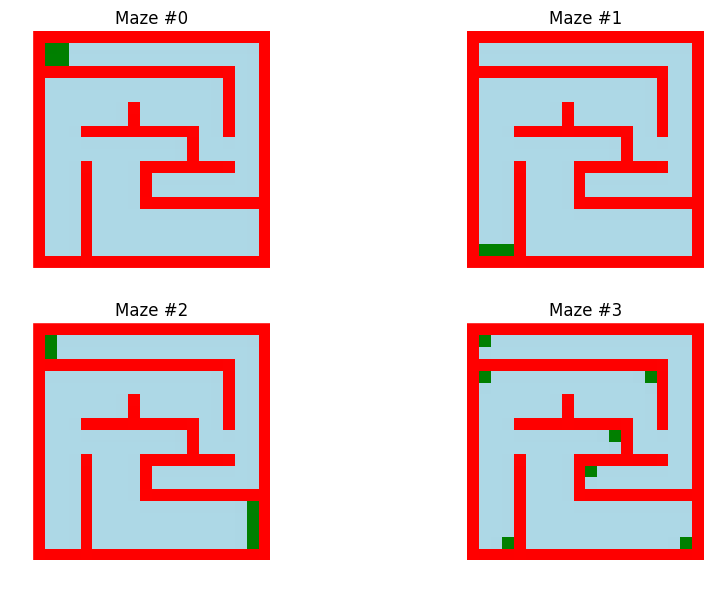

In [29]:
mazes, policy_maze = read_mazes()
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for i, maze in enumerate(mazes):
    plot_maze(axes.flat[i], maze, 'Maze #{}'.format(i))
fig.tight_layout()

### H13.1 (b) Transition model

State:
* 0 = Reward
* 1 = Unrewarded
* 2 = Not accessible
* 3 = Right policy
* 4 = Down policy
* 5 = Left policy
* 6 = Up policy

Actions:
* 1 = Move right
* 2 = Move down
* 3 = Move left
* 4 = Move up

In [30]:
def move(maze, state, action):
    width, height = maze.shape
    nx, ny = state + movements[action]
    if nx < 0 or nx >= width or ny < 0 or ny >= height:
        raise ValueError('Invalid action {}: Destination at ({}, {}) is out of bounds!'.format(action, nx, ny))
    if maze[nx, ny] == STATE_WALL:
        return state
        # raise ValueError('Invalid action {}: Destination at ({}, {}) is a wall!'.format(action, nx, ny))
    return (nx, ny)

def transition_model(maze, state, next_state, action):
    try:
        return int(next_state == move(maze, state, action))
    except ValueError:
        # thrown if the result of move() is out of bounds.
        return 0

def get_states(maze, ignore_walls=False):
    states = list(itertools.product(range(maze.shape[0]), range(maze.shape[1])))
    if ignore_walls:
        states = [x for x in states if maze[x[0], x[1]] != STATE_WALL]
    return states

In [31]:
maze = mazes[0]
states = get_states(maze)
sums = np.zeros((len(maze.flat), len(actions)))
values = []
for i, state in enumerate(states):
    if maze[state[0], state[1]] == STATE_WALL:
        sums[i] = [-1] * len(actions)
        continue
    for k, action in enumerate(actions):
        # Store transition model value in sums
        for x, y in states:
            sums[i, k] += transition_model(maze, state, (x, y), action)
        values.append(sums[i, k])

(-0.1, 1.1)

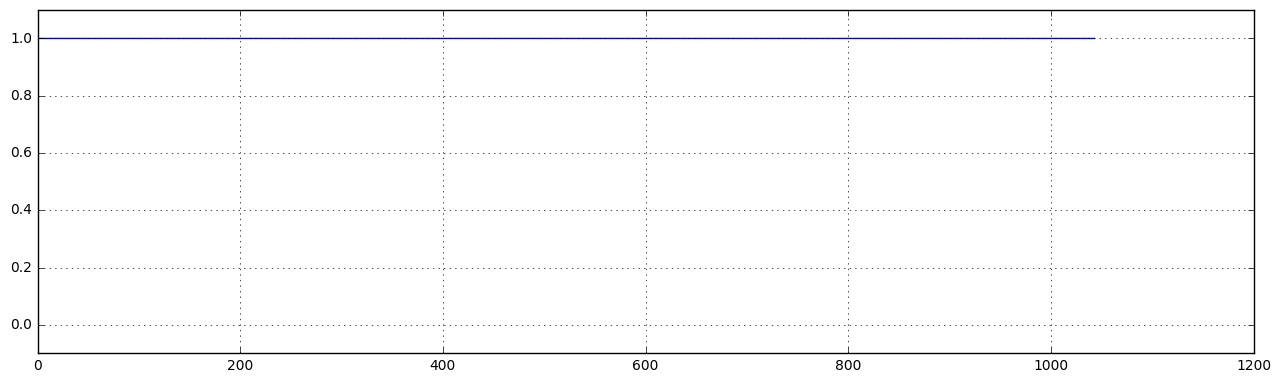

In [32]:
# plot(enum=True)
ax = plot(sorted(values), enum=True)
ax.set_ylim([-0.1, 1.1])

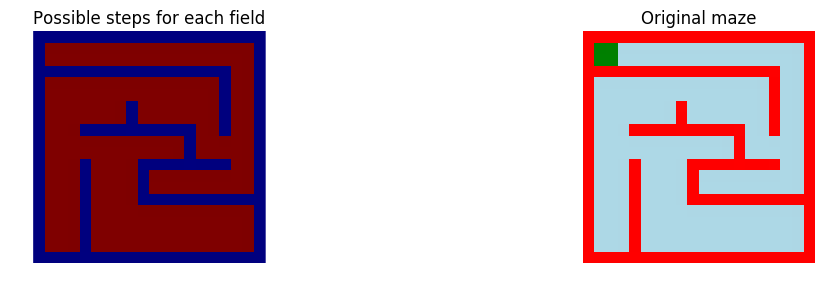

In [33]:
possible_steps = sums.reshape(*maze.shape, len(actions)).sum(axis=2)
fig, axes = plt.subplots(1, 2, figsize=(13, 3))
axes[0].imshow(possible_steps, interpolation='none')
axes[0].axis('off')
axes[0].set_title('Possible steps for each field')
plot_maze(axes[1], maze, 'Original maze')

### H13.1 (c) Policy evaluation

In [34]:
def simple_policy(maze, state, action):
    return 1 / len(actions)

def reward(maze, state, action):
    return int(maze[state[0], state[1]] == STATE_REWARDED)

def transition_model(maze, state, next_state, action):
    try:
        return int(next_state == move(maze, state, action))
    except ValueError:
        # thrown if the result of move() is out of bounds.
        return 0

def controlled_reward(maze, state, policy_func, reward_func):
    # From Bellman equation: "controlled" reward function
    return np.sum([policy_func(maze, state, action) * reward_func(maze, state, action)
                   for action in actions])

def controlled_transition(maze, state_i, state_j, policy_func, transition_func):
    # From Bellman equation: "controlled" transition function
    return np.sum([policy_func(maze, state_i, action) * transition_func(maze, state_i, state_j, action)
                   for action in actions])

def analytical_values(maze, policy_func=simple_policy, reward_func=reward, transition_func=transition_model, gamma=0.9):
    states = get_states(maze, ignore_walls=False)
    r = np.array([controlled_reward(maze, state, policy_func, reward_func)
                  for state in states])
    P = np.array([[controlled_transition(maze, state_i, state_j, policy_func, transition_func)
                   for state_i in states]
                  for state_j in states])
    I = np.eye(len(states))
    V = np.linalg.inv(I - gamma * P).dot(r)
    return r, P, V

def plot_analytical_values(v, ax=None, title=''):
    v = np.rot90(v.reshape(20, 20).T)
    if ax:
        ax.pcolormesh(v, norm=colors.LogNorm())
    else:
        aximg = plt.pcolormesh(v, norm=colors.LogNorm())
        ax = aximg.axes
    ax.axis('off')
    ax.set_title(title)
    return ax

vs = [analytical_values(maze, gamma=0.9) for maze in mazes]

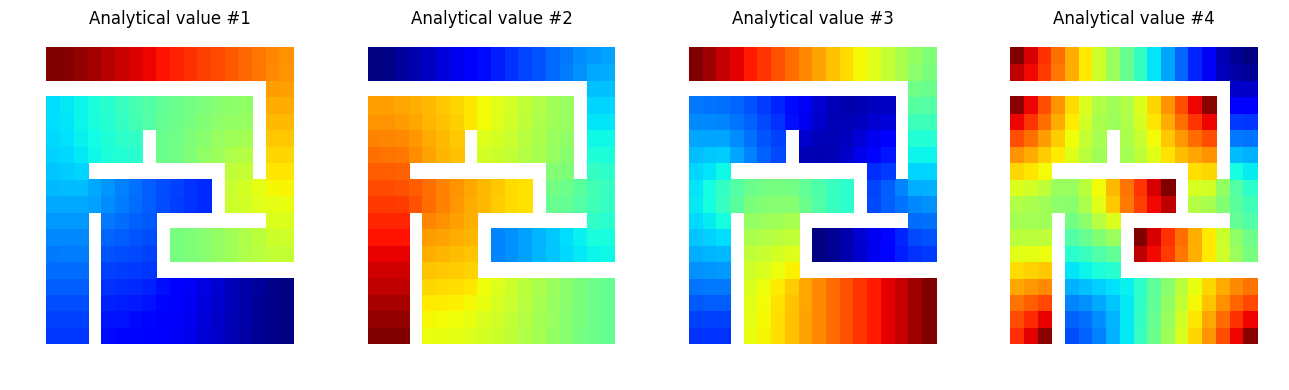

In [35]:
fig, axes = plt.subplots(1, 4, figsize=(13, 4))
for i, v in enumerate(vs):
    plot_analytical_values(v[2], axes[i], 'Analytical value #{}'.format(i + 1))
fig.tight_layout()

### H13.1 (d) Bellman - Value iteration

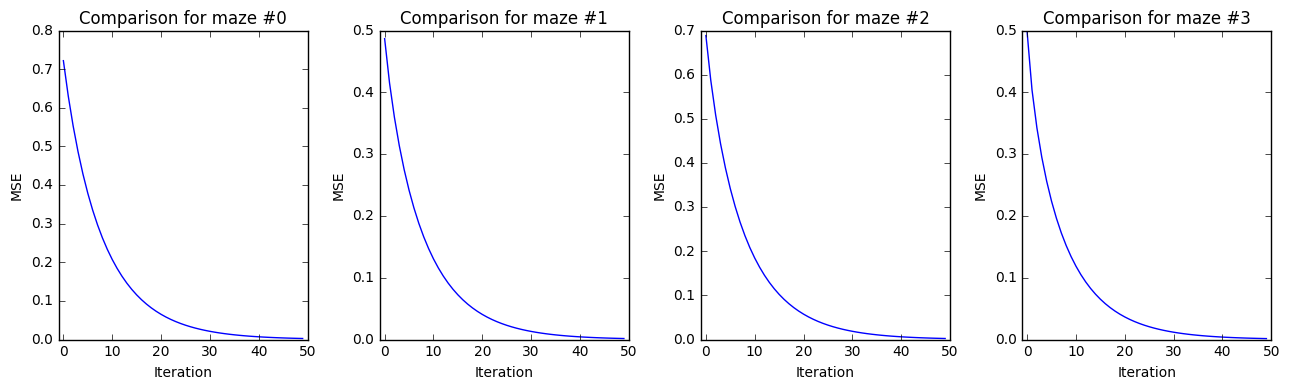

In [36]:
def value_iteration(maze, r, P, v, gamma=0.9, steps=50, nr=-1):
    approx = np.zeros((steps, len(r)))
    for i in range(steps):
        if i == 0:
            continue
        approx[i] = r + gamma * P.dot(approx[i - 1])
    return approx

def mse(v, approx):
    diff = v - approx
    return np.sqrt(np.mean(diff * diff))

fig, axes = plt.subplots(1, 4, figsize=(13, 4))
vs_approx = [value_iteration(maze, *vs[i]) for (i, maze) in enumerate(mazes)]
for i, maze in enumerate(mazes):
    r, P, v = vs[i]
    approximations = value_iteration(maze, r, P, v, nr=i)
    mses = [mse(np.array(v.flat), approx) for approx in approximations]
    axes[i].plot(mses)
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel('MSE')
    axes[i].set_title('Comparison for maze #{}'.format(i))
    axes[i].set_xlim([-1, 50])
fig.tight_layout()

### H13.2 (a) Indicated policy

In [37]:
def good_policy(maze, state, action):
    state_value = maze[state[0], state[1]]
    if state_value in (STATE_UNREWARDED, STATE_REWARDED):
        return 1 / len(actions)
    if state_value in (STATE_RIGHT, STATE_DOWN, STATE_LEFT, STATE_UP):
        return int(state_value - 3 == action)
    return 0

policy_v_simple = analytical_values(policy_maze)
policy_v = analytical_values(policy_maze, policy_func=good_policy)

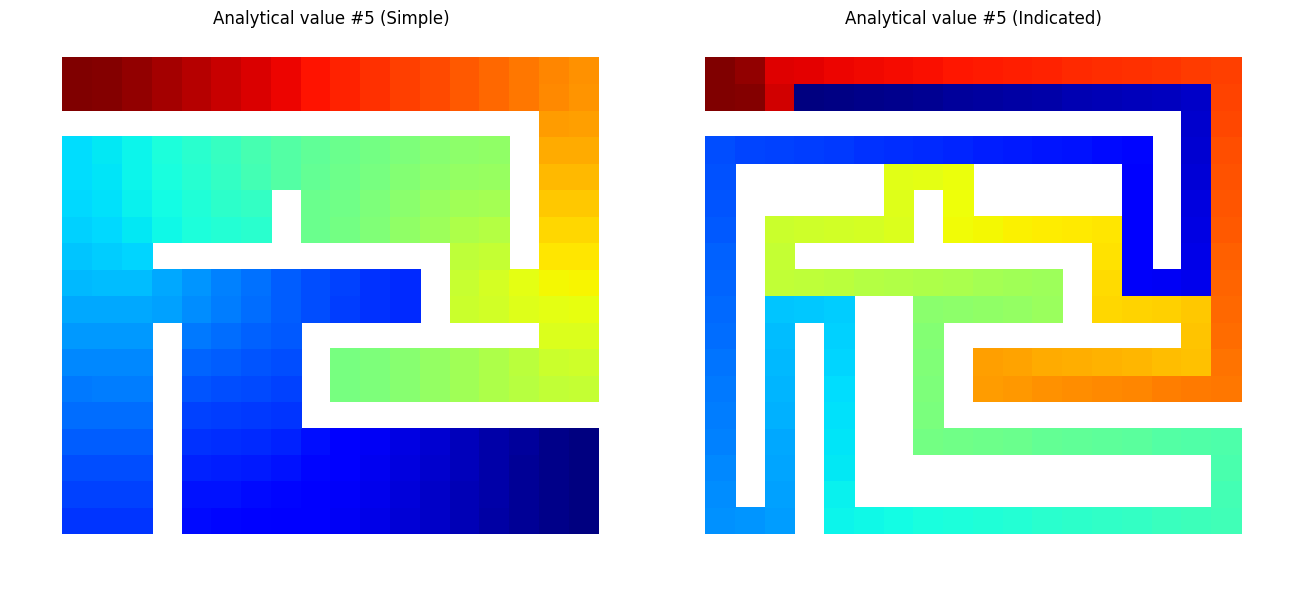

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
plot_analytical_values(policy_v_simple[2], axes[0], 'Analytical value #5 (Simple)')
plot_analytical_values(policy_v[2], axes[1], 'Analytical value #5 (Indicated)')
fig.tight_layout()

### H13.2 (b) Find optimal policy

In [39]:
maze_opt_str = """
####################
#XX<<<<<<<<<<<<<<<^#
#XX<<<<<<<<<<<<<<<^#
#################^^#
#>>>>>>>>>>>>>vv#^^#
#>>>>>>>>>>>>>vv#^^#
#^^^^^^^#>>>>>vv#^^#
#^^^^^^^#>>>>>vv#^^#
#^^^##########vv#^^#
#^^^<<<<<<<<<#>>>^^#
#^^^<<<<<<<<<#>>>^^#
#^^^#^<<<########^^#
#^^^#^<<<#>>>>>>>^^#
#^^^#^<<<#>>>>>>>^^#
#^^^#^<<<###########
#^^^#^<<<<<<<<<<<<<#
#^^^#^<<<<<<<<<<<<<#
#^^^#^<<<<<<<<<<<<<#
#^^^#^<<<<<<<<<<<<<#
####################
"""

maze_opt = np.reshape(transform(replace_signs([maze_opt_str])), (20, 20))
policy_v_opt = analytical_values(maze_opt, policy_func=good_policy)

In [40]:
def good_policy(maze, state, action):
    state_value = maze[state[0], state[1]]
    if state_value in (STATE_UNREWARDED, STATE_REWARDED):
        return 1 / len(actions)
    if state_value in (STATE_RIGHT, STATE_DOWN, STATE_LEFT, STATE_UP):
        return int(state_value - 3 == action)
    return 0

policy_v_opt = analytical_values(maze_opt, policy_func=good_policy)

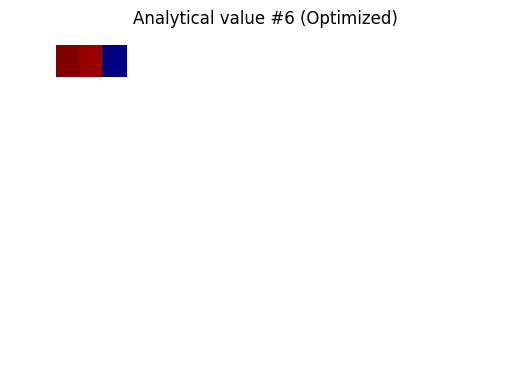

In [41]:
ax = plot_analytical_values(policy_v_opt[2], title='Analytical value #6 (Optimized)')

### H13.2 (c) Another optimal policy

In [42]:
maze_opt_str2 = """
####################
#XX<<<<<<<<<<<<<<<<#
#XX<<<<<<<<<<<<<<<<#
#################^<#
#vvvvvvvvvvvvvvv#^<#
#>>>>>>>>vvvvvvv#^<#
#>>>>>>^#vvvvvvv#^<#
#>>>>>>^#>>>>>>v#^<#
#>>^##########>v#^<#
#>>^<<<<<<<<<#>>>^<#
#>>^^^^^^^^^^#^^^^<#
#>>^#^^^^########^<#
#>>^#^^^^#>>>>>>>^<#
#>>^#^^^^#^^^^^^^^<#
#>>^#^^^^###########
#>>^#^^^^<<<<<<<<<<#
#>>^#^^^^^^^^^^^^^^#
#>>^#^^^^^^^^^^^^^^#
#>>^#^^^^^^^^^^^^^^#
####################
"""

maze_opt2 = np.reshape(transform(replace_signs([maze_opt_str2])), (20, 20))
policy_v_opt2 = analytical_values(maze_opt2, policy_func=good_policy)

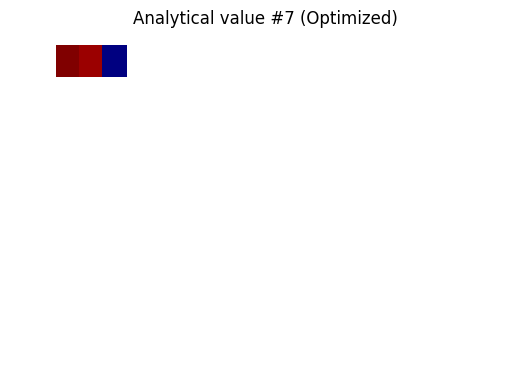

In [43]:
ax = plot_analytical_values(policy_v_opt2[2], title='Analytical value #7 (Optimized)')

### H13.2 (d) Optimal Policy - similar to the Uniform Policy (Counter example)

Uniform policy fails if you include punished states and slopes which can't be changed by the policy.

Original maze:
```
#######
#    X#
# # >O#
#     #
#######
```

Optimal solution:
```
#######
#>>>>X#
#^#^>O#
#>>^<<#
#######
```